### Check calib by time

In [1]:
import numpy as np
import scipy, h5py
import scipy.stats as stats
import os,sys
import tables
import scipy.io as scio
import matplotlib.pyplot as plt
import uproot, argparse
from scipy.optimize import minimize
from scipy import interpolate
from numpy.polynomial import legendre as LG
from scipy import special
import warnings

/home/orv/gentoo/usr/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


##### load coeff

In [2]:
h = tables.open_file('../calib/Time_coeff.h5','r')
coeff = h.root.coeff[:]
h.close()
cut, fitcut = coeff.shape

In [3]:
# physical constant
Light_yield = 4285*0.88 # light yield
Att_LS = 18 # attenuation length of LS
Att_Wtr = 300 # attenuation length of water
tau_r = 1.6 # fast time constant
TTS = 5.5/2.355
QE = 0.20
PMT_radius = 0.254
c = 2.99792e8
n = 1.48
shell = 0.6 # Acrylic

In [4]:
def Likelihood_Time(vertex, *args):
    coeff, PMT_pos, fired, time, cut = args
    y = time
    # fixed axis
    z = np.sqrt(np.sum(vertex[1:4]**2))
    cos_theta = np.sum(vertex[1:4]*PMT_pos,axis=1)\
        /np.sqrt(np.sum(vertex[1:4]**2)*np.sum(PMT_pos**2,axis=1))
    # accurancy and nan value
    cos_theta = np.nan_to_num(cos_theta)
    cos_theta[cos_theta>1] = 1
    cos_theta[cos_theta<-1] =-1

    cos_total = cos_theta[fired]
    
    size = np.size(cos_total)
    x = np.zeros((size, cut))
    # legendre coeff
    for i in np.arange(0,cut):
        c = np.zeros(cut)
        c[i] = 1
        x[:,i] = LG.legval(cos_total,c)

    k = np.zeros((1,cut))
    for i in np.arange(cut):
        # cubic interp
        if(np.abs(z)>0.65):
            z = 0.65*np.sign(z)
        k[0,i] = np.sum(np.polynomial.legendre.legval(z,coeff[i,:]))
    
    #k[0] = k[0] + np.log(vertex[0])
    k[0,0] = vertex[0]
    T_i = np.dot(x, np.transpose(k))
    L = Likelihood_quantile(y, T_i[:,0], 0.2, 0.3)
    return L

In [5]:
def Likelihood_Time_Check(vertex, *args):
    coeff, PMT_pos, fired, time, cut = args
    y = time
    # fixed axis
    z = np.sqrt(np.sum(vertex[1:4]**2))
    cos_theta = np.sum(vertex[1:4]*PMT_pos,axis=1)\
        /np.sqrt(np.sum(vertex[1:4]**2)*np.sum(PMT_pos**2,axis=1))
    # accurancy and nan value
    cos_theta = np.nan_to_num(cos_theta)
    cos_theta[cos_theta>1] = 1
    cos_theta[cos_theta<-1] =-1

    cos_total = cos_theta[fired]
    
    size = np.size(cos_total)
    x = np.zeros((size, cut))
    # legendre coeff
    for i in np.arange(0,cut):
        c = np.zeros(cut)
        c[i] = 1
        x[:,i] = LG.legval(cos_total,c)

    k = np.zeros((1,cut))
    for i in np.arange(cut):
        # cubic interp
        if(np.abs(z)>0.65):
            z = 0.65*np.sign(z)
        k[0,i] = np.sum(np.polynomial.legendre.legval(z,coeff[i,:]))
    
    #k[0] = k[0] + np.log(vertex[0])
    k[0,0] = vertex[0]
    T_i = np.dot(x, np.transpose(k))
    L = Likelihood_quantile(y, T_i[:,0], 0.2, 0.3)
    return T_i

In [6]:
def Likelihood_quantile(y, T_i, tau, ts):
    less = T_i[y<T_i] - y[y<T_i]
    more = y[y>=T_i] - T_i[y>=T_i]

    R = (1-tau)*np.sum(less) + tau*np.sum(more)
    #log_Likelihood = exp
    return R

In [7]:
def con_sph(args):
    E_min,\
    E_max,\
    tau_min,\
    tau_max,\
    t0_min,\
    t0_max\
    = args
    cons = ({'type': 'ineq', 'fun': lambda x: shell**2 - (x[1]**2 + x[2]**2 + x[3]**2)})
    return cons

In [8]:
def con_sph1(args):
    E_min,\
    E_max,\
    tau_min,\
    tau_max,\
    t0_min,\
    t0_max\
    = args
    cons = ({'type': 'ineq', 'fun': lambda x: 0.1**2 - (x[1]**2 + x[2]**2 + x[3]**2)})
    return cons

In [9]:
def ReadPMT():
    f = open(r"./PMT1t.txt")
    line = f.readline()
    data_list = [] 
    while line:
        num = list(map(float,line.split()))
        data_list.append(num)
        line = f.readline()
    f.close()
    PMT_pos = np.array(data_list)
    return PMT_pos

/home/orv/gentoo/usr/lib64/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


545.1906163499112 2448.308207918536
552.1059710584203 2478.80947785652


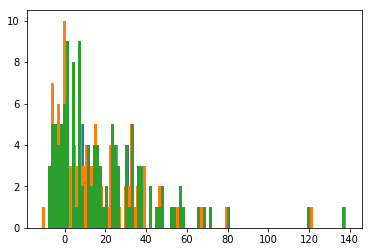

In [34]:
PMT_pos = ReadPMT()
event_count = 0
# Reconstruction
fid = '../calib/1.8MeV/calib+0.01.h5'# input file .h5
args = PMT_pos, event_count

h = tables.open_file(fid,'r')
rawdata = h.root.GroundTruth
EventID = rawdata[:]['EventID']
ChannelID = rawdata[:]['ChannelID']
Time = rawdata[:]['PETime']

i = 1

index = (EventID==i)
pe_array = np.zeros(np.size(PMT_pos[:,1])) # Photons on each PMT (PMT size * 1 vector)
fired_PMT = ChannelID[index]
for j in np.arange(np.size(fired_PMT)):
    pe_array[fired_PMT[j]] = pe_array[fired_PMT[j]]+1

time_array = Time[index]        
fired_PMT = fired_PMT.astype(int)
# initial result
result_vertex = np.empty((0,6)) # reconstructed vertex
# initial value x[0] = [1,6]

x0 = np.zeros((1,4))
x0[0][0] = pe_array.sum()/60
x0[0][1] = np.sum(pe_array*PMT_pos[:,0])/np.sum(pe_array)
x0[0][2] = np.sum(pe_array*PMT_pos[:,1])/np.sum(pe_array)
x0[0][3] = np.sum(pe_array*PMT_pos[:,2])/np.sum(pe_array)
# Constraints
E_min = 0.01
E_max = 10
tau_min = 0.01
tau_max = 100
t0_min = -300
t0_max = 300

# initial value
x0 = np.zeros((1,4))
x0[0][0] = pe_array.sum()/60
x0[0][1] = np.sum(pe_array*PMT_pos[:,0])/np.sum(pe_array)
x0[0][2] = np.sum(pe_array*PMT_pos[:,1])/np.sum(pe_array)
x0[0][3] = np.sum(pe_array*PMT_pos[:,2])/np.sum(pe_array)

if(np.sqrt(np.sum(x0**2))>0.65):
    x0 = x0/np.sqrt(np.sum(x0**2))*0.65
con_args = E_min, E_max, tau_min, tau_max, t0_min, t0_max
cons_sph = con_sph(con_args)
record = np.zeros((1,4))

result = minimize(Likelihood_Time, x0, method='SLSQP',constraints=cons_sph, args = (coeff, PMT_pos, fired_PMT, time_array, cut))

x0[0][1] = 0
x0[0][2] = 0
x0[0][3] = 0
cons_sph = con_sph1(con_args)
result1 = minimize(Likelihood_Time, x0, method='SLSQP',constraints=cons_sph, args = (coeff, PMT_pos, fired_PMT, time_array, cut))
args = (coeff, PMT_pos, fired_PMT, time_array, cut)
T1 = Likelihood_Time_Check(result.x, *(coeff, PMT_pos, fired_PMT, time_array, cut))
T2 = Likelihood_Time_Check(result1.x, *(coeff, PMT_pos, fired_PMT, time_array, cut))

R1 = Likelihood_quantile(time_array, T1[:,0], 0.2, 0.3)
R2 = Likelihood_quantile(time_array, T2[:,0], 0.2, 0.3)
print(R1, np.sum(np.abs(time_array-T1[:,0])))
print(R2, np.sum(np.abs(time_array-T2[:,0])))
import matplotlib.pyplot as plt
plt.hist(time_array - T2[:,0], bins= 100)
plt.hist(time_array - T1[:,0], bins= 100)
plt.hist(time_array - T2[0], bins= 100)
plt.show()

In [20]:
T1[:,0]

array([283.81195916, 283.81195916, 284.10744855, 284.10744855,
       280.61596668, 280.61596668, 280.61596668, 280.61596668,
       280.61596668, 281.26760638, 281.26760638, 281.26760638,
       281.26760638, 281.26760638, 281.26760638, 280.89008231,
       280.89008231, 280.89008231, 280.99999905, 280.99999905,
       280.99999905, 281.27190718, 281.27190718, 281.27190718,
       281.27190718, 281.27190718, 281.27190718, 281.27190718,
       281.11777736, 281.11777736, 281.11777736, 281.11777736,
       281.11777736, 281.11777736, 281.11777736, 281.81672863,
       281.81672863, 281.81672863, 281.81672863, 281.81672863,
       281.81672863, 282.48771787, 282.48771787, 282.48771787,
       282.48771787, 280.32752042, 280.32752042, 280.32752042,
       280.32752042, 280.32752042, 280.32752042, 280.32752042,
       281.88505157, 281.88505157, 280.33138807, 280.33138807,
       280.33138807, 280.33138807, 280.33138807, 280.25144129,
       280.25144129, 280.25144129, 280.20866345, 280.20